# Machine Learning Model Notebook for On-Device Machine Learning for vibration based predictive maintainance of industrial induction motors using MEMS sensors.

### imports

In [3]:
import os
import random
import pickle
import json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, callbacks, utils

### file loading and hyperparameters

In [5]:
filemap = {
    'motor_off': 'motor_off.xlsx',
    'motor_on': 'motor_on.xlsx',
    'motor_on_nofan': 'motor_on_nofan.xlsx',
    'motor_on_badfan': 'motor_on_badfan.xlsx'
}
data_columns = ['ax','ay','az','gx','gy','gz']
label_column = 'class_label'
time_column = 'timestamp'
fs = 40.0

# Made changes here, 50% overlap considered
window_size = 64
step = window_size // 2

test_size = 0.2
val_size = 0.1

batch_size = 64
epochs = 60

In [6]:
frames = []

for label,fname in filemap.items():
    df = pd.read_excel(fname)
    frames.append(df)

df = pd.concat(frames)
print ('combined shape:', df.shape)

combined shape: (144000, 8)


## preprocessing

In [8]:
data_arr = df[data_columns].values.astype('float32')
labels_arr = df[label_column].values

print ('data shape (samples, channels):', data_arr.shape)

data shape (samples, channels): (144000, 6)


In [9]:
# sliding window generator

def make_windows(data, labels, window_size = window_size, step = step):
    x = []
    y = []
    n_samples = data.shape[0]

    for start in range(0, n_samples - window_size + 1, step):
        end = start + window_size
        win = data[start:end]
        lab_win = labels[start:end]
        vals, counts = np.unique(lab_win, return_counts = True)
        label = vals[np.argmax(counts)]
        x.append(win)
        y.append(label)
    X = np.array(x)
    y = np.array(y)
    return X,y

X,y = make_windows(data_arr, labels_arr, window_size, step)
print('windows created: X-shape:', X.shape, 'y shape:', y.shape)

windows created: X-shape: (4499, 64, 6) y shape: (4499,)


In [10]:
# encode labels
#le = LabelEncoder()
#y_enc = le.fit_transform(y)
#print('label classes:', le.classes_)

# Robust conversion of label strings/ints -> integer indices (works if y contains ints, strings, or mixed)
import numpy as np
import json

# `y` is the 1D array of window labels returned by make_windows (e.g. ['motor_on', 'motor_off', 0, 1, ...])
# Create classes in deterministic order. Use np.unique which sorts; if you prefer order-of-appearance use the commented alternative.
classes = np.unique(y).tolist()             # sorted unique values
# If you prefer first-appearance order (not sorted), uncomment:
# import pandas as pd
# classes = pd.Series(y).astype(object).unique().tolist()

num_classes = len(classes)
print("Detected classes (from np.unique):", classes)

# Build mapping: try to be flexible about types (map both original and string form to same index)
class_to_index = {}
for i, c in enumerate(classes):
    class_to_index[c] = i
    # also map the stringified form to be defensive (so '0' maps to 0 if 0 is in classes)
    try:
        class_to_index[str(c)] = i
    except Exception:
        pass

print("Initial class_to_index keys (sample):", list(class_to_index.items())[:10])

# Now build y_idx robustly: try direct lookup, then try string lookup, else raise a clearer error
y_idx_list = []
missing_values = set()
for lbl in y:
    if lbl in class_to_index:
        y_idx_list.append(class_to_index[lbl])
    elif str(lbl) in class_to_index:
        y_idx_list.append(class_to_index[str(lbl)])
    else:
        # collect missing and continue (we'll raise after loop to show all missing values)
        missing_values.add(lbl)
        y_idx_list.append(-1)  # placeholder

if missing_values:
    raise KeyError(
        "Some labels from `y` were not found in computed classes. "
        f"Missing examples (up to 20 shown): {list(missing_values)[:20]}. "
        "Inspect `y` for inconsistent types or unexpected values."
    )

y_idx = np.array(y_idx_list, dtype=np.int32)
print("Converted y -> y_idx shape:", y_idx.shape, "num_classes:", num_classes)

Detected classes (from np.unique): [0, 1, 2, 3]
Initial class_to_index keys (sample): [(0, 0), ('0', 0), (1, 1), ('1', 1), (2, 2), ('2', 2), (3, 3), ('3', 3)]
Converted y -> y_idx shape: (4499,) num_classes: 4


In [11]:
# train/test split (stratified by window label)
X_train, X_test, y_train, y_test = train_test_split(X, y_idx, test_size=test_size, stratify=y_idx, random_state=42)

In [12]:
# splitting train into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=42)

In [13]:
print('train/test/val split shape:', X_train.shape, X_val.shape, X_test.shape)

train/test/val split shape: (3239, 64, 6) (360, 64, 6) (900, 64, 6)


In [14]:
# scaling channels using standard scaler and then fitting on training windows + reshaping to fit scaler and then reshaping back
n_channels = X.shape[2]
scaler = StandardScaler()
reshaped = X_train.reshape(-1, n_channels)
scaler.fit(reshaped)

X_train_scaled = scaler.transform(X_train.reshape(-1, n_channels)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_channels)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_channels)).reshape(X_test.shape)

In [15]:
# converting integer label indices to one-hot (for model.fit)
# num_classes already set from classes list created earlier
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat   = tf.keras.utils.to_categorical(y_val,   num_classes=num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test,  num_classes=num_classes)

print("y_train_cat shape:", y_train_cat.shape, "num_classes:", num_classes)

y_train_cat shape: (3239, 4) num_classes: 4


In [16]:
# For Keras: ensure dtype float32
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

## model architecture

In [18]:
model = models.Sequential([
    layers.Input(shape = (window_size, n_channels)),

    layers.Conv1D(20, kernel_size = 7, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)), # 32
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.2),
    layers.MaxPooling1D(2),

    layers.Conv1D(40, kernel_size = 5, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)), # 64
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.25),
    layers.MaxPooling1D(2),

    layers.Conv1D(20, kernel_size = 3, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)), # 32
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling1D(),

    layers.Dense(64, kernel_regularizer = regularizers.l2(1e-4)), # 256
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    #layers.Dense(128, kernel_regularizer = regularizers.l2(1e-4)),
    #layers.BatchNormalization(),
    #layers.Activation('relu'),
    #layers.Dropout(0.2),

    layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 20)         │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 64, 20)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 40)         │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 40)         │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 32, 40)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 20)         │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 20)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,500 (37.11 KB)

 Trainable params: 9,212 (35.98 KB)

 Non-trainable params: 288 (1.12 KB)

## model training

In [20]:
# callbacks
es = callbacks.EarlyStopping (monitor = 'val_loss', patience = 5, restore_best_weights = True)
rl = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)

In [21]:
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data = (X_val_scaled, y_val_cat),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [es,rl]
)

Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3927 - loss: 1.4193 - val_accuracy: 0.4528 - val_loss: 1.2417 - learning_rate: 0.0010
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5400 - loss: 1.0484 - val_accuracy: 0.6306 - val_loss: 1.0584 - learning_rate: 0.0010
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6271 - loss: 0.8643 - val_accuracy: 0.6972 - val_loss: 0.8649 - learning_rate: 0.0010
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6924 - loss: 0.6964 - val_accuracy: 0.7528 - val_loss: 0.6580 - learning_rate: 0.0010
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7124 - loss: 0.6342 - val_accuracy: 0.7944 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7461 - loss: 0.5650 - val_accuracy: 0.8444 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7565 - loss: 0.5225 - val_accuracy: 

## evaluation

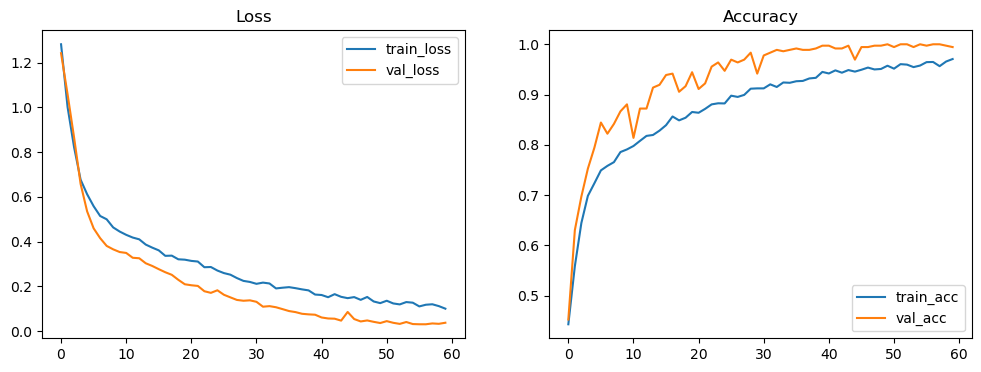

In [23]:
# training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [24]:
# eval
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose = 0)
print(f'test loss: {test_loss: .4f}, test accuracy:{test_acc: .4f}')

test loss:  0.0352, test accuracy: 0.9933


In [25]:
# predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis = 1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
# classification report
print ('classification report:')
print(classification_report(y_test, y_pred, target_names = [str(c) for c in classes]))

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       225
           1       0.99      1.00      0.99       225
           2       0.99      0.98      0.99       225
           3       0.99      1.00      0.99       225

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



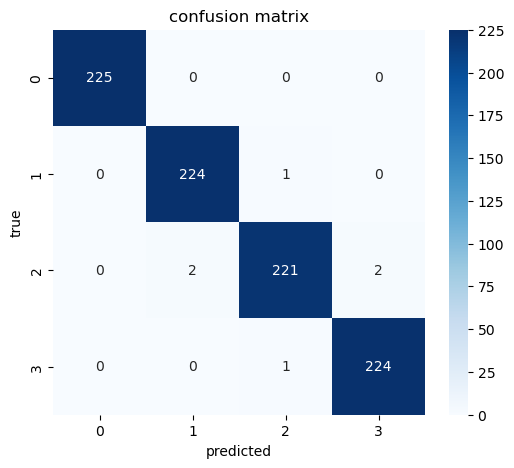

In [27]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show()

### compiling and exporting model

In [29]:
# Save Keras single-file model
model.save("motor_model.keras", overwrite=True)
print("Saved model -> motor_model.keras")

# Save scaler used during training (you used StandardScaler in notebook)
joblib.dump(scaler, "scaler.pkl")
print("Saved scaler -> scaler.pkl")

# Save metadata containing the classes list and preprocessing params
meta = {
    "window_size": window_size,
    "step": step,
    "n_channels": n_channels,
    "data_columns": data_columns,
    "classes": classes
}
with open("model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved model_meta.json -> contains classes and window metadata")

Saved model -> motor_model.keras
Saved scaler -> scaler.pkl
Saved model_meta.json -> contains classes and window metadata
